AUDIO AND MIDI FILES EXTRACTING AND PARSING



In [ ]:
!pip install pretty_midi

In [ ]:
!sudo apt install -y fluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple

In [ ]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

In [ ]:
data_dir = pathlib.Path('MIDI_Files/maestro-v2.0.0')

def download_data():
  if not data_dir.exists():
    tf.keras.utils.get_file(
        'maestro-v2.0.0-midi.zip',
        origin='https://storage.googleapis.com/magentadata/datasets/maestro/v2.0.0/maestro-v2.0.0-midi.zip',
        extract=True,
        cache_dir='.', cache_subdir='MIDI_Files',
    )

def sample_file(n):
  filenames = glob.glob(str(data_dir/'**/*.mid*'))
  sample_file = filenames[n]
  return sample_file

def sample_file_pm(n):
  filenames = glob.glob(str(data_dir/'**/*.mid*'))
  sample_file = filenames[n]
  pm = pretty_midi.PrettyMIDI(sample_file)
  return pm

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=16000)


In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
download_data()

59243107/59243107 [==============================] - 1s 0us/step


In [ ]:
md_file = sample_file(2)
raw_notes = midi_to_notes(md_file)
raw_notes

,pitch,start,end,step,duration
0,63,0.701823,1.132812,0.000000,0.430990
1,64,0.971354,1.125000,0.269531,0.153646
2,58,1.316406,1.481771,0.345052,0.165365
3,51,1.319010,1.407552,0.002604,0.088542
4,54,1.335938,1.451823,0.016927,0.115885
...,...,...,...,...,...
3942,46,256.167969,256.561198,0.694010,0.393229
3943,55,256.529948,256.996094,0.361979,0.466146
3944,46,256.924479,257.500000,0.394531,0.575521
3945,55,257.411458,259.108073,0.486979,1.696615


In [ ]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 6))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="black", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

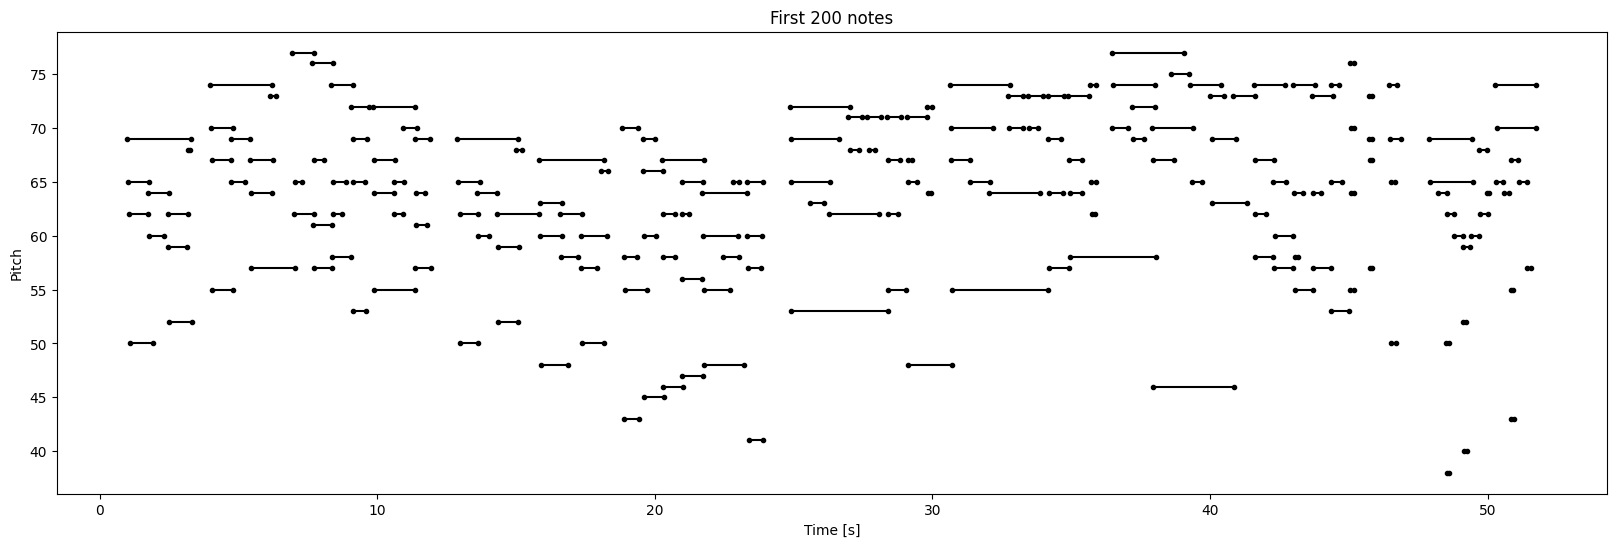

In [ ]:
plot_piano_roll(raw_notes, 200)

In [ ]:
from scipy.stats import norm

def plot_distributions2(notes: pd.DataFrame, drop_percentile=2.5):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # pitch distribution
    sns.histplot(notes, x="pitch", bins=20, ax=axs[0], kde=True, stat="density")
    axs[0].set_title("Pitch Distribution")
    mu, std = notes["pitch"].mean(), notes["pitch"].std()
    x_axis = np.linspace(mu - 3*std, mu + 3*std, 100)
    axs[0].plot(x_axis, norm.pdf(x_axis, mu, std), color="black", linewidth=2.5)

    # step distribution
    max_step = np.percentile(notes['step'], 100 - drop_percentile)
    sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21), ax=axs[1], kde=True, stat="density")
    axs[1].set_title("Step Distribution")
    mu, std = notes["step"].mean(), notes["step"].std()
    x_axis = np.linspace(mu - 3*std, mu + 3*std, 100)
    axs[1].plot(x_axis, norm.pdf(x_axis, mu, std), color="black", linewidth=2.5)

    # duration distribution
    max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
    sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21), ax=axs[2], kde=True, stat="density")
    axs[2].set_title("Duration Distribution")
    mu, std = notes["duration"].mean(), notes["duration"].std()
    x_axis = np.linspace(mu - 3*std, mu + 3*std, 100)
    axs[2].plot(x_axis, norm.pdf(x_axis, mu, std), color="black", linewidth=2.5)

    plt.show()


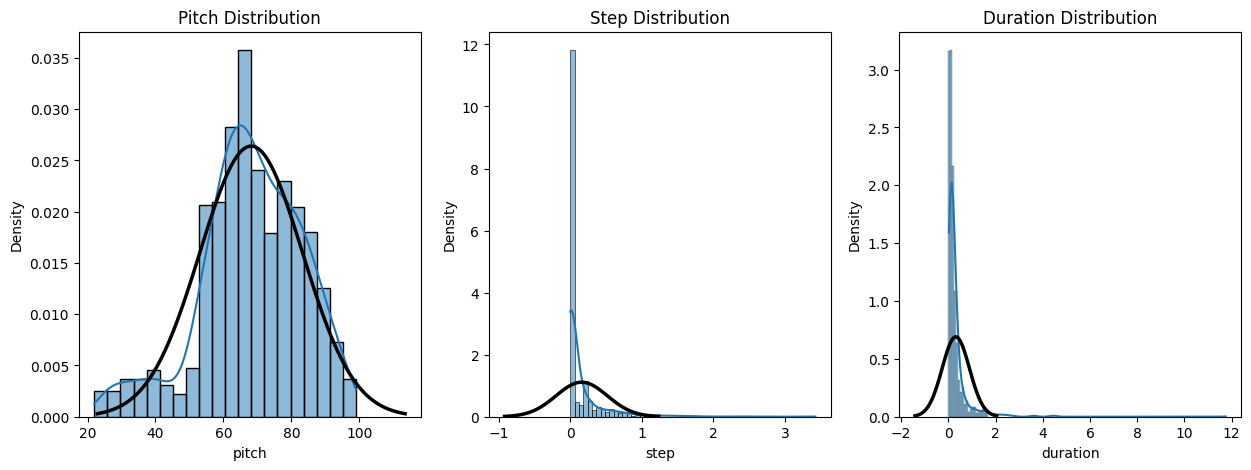

In [ ]:
plot_distributions2(raw_notes)

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
def n_notes(num):
  num_files = num
  all_notes = []
  filenames = glob.glob(str(data_dir/'**/*.mid*'))
  for md_file in filenames[:num_files]:
    notes = midi_to_notes(md_file)
    all_notes.append(notes)

  all_notes = pd.concat(all_notes)
  n_notes = len(all_notes)
  return all_notes

def convert_to_tensor(all_notes: pd.DataFrame):
  key_order = ['pitch', 'step', 'duration']
  a = [all_notes[key] for key in key_order]
  train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
  notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
  return notes_ds


In [ ]:
n = 5
train_notes = n_notes(n)
notes_ds = convert_to_tensor(n_notes(n))

In [ ]:
print(train_notes, notes_ds)

      pitch       start         end      step  duration
0        62    1.026042    1.213542  0.000000  0.187500
1        50    1.048177    1.233073  0.022135  0.184896
2        38    1.054688    1.220052  0.006510  0.165365
3        61    1.230469    1.281250  0.175781  0.050781
4        37    1.238281    1.286458  0.007812  0.048177
...     ...         ...         ...       ...       ...
3747     65  470.890625  474.541667  0.032552  3.651042
3748     62  470.907552  474.161458  0.016927  3.253906
3749     58  470.927083  474.350260  0.019531  3.423177
3750     53  470.941406  474.243490  0.014323  3.302083
3751     46  470.946615  474.252604  0.005208  3.305990

[26157 rows x 5 columns] <_TensorSliceDataset element_spec=TensorSpec(shape=(3,), dtype=tf.float64, name=None)>


In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  key_order = ['pitch', 'step', 'duration']
  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}


    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.484375   0.         0.1875    ]
 [0.390625   0.02213542 0.18489583]
 [0.296875   0.00651042 0.16536458]
 [0.4765625  0.17578125 0.05078125]
 [0.2890625  0.0078125  0.04817708]
 [0.4609375  0.18619792 0.02864583]
 [0.2734375  0.01302083 0.03515625]
 [0.4453125  0.16927083 0.03255208]
 [0.2578125  0.01302083 0.03515625]
 [0.4765625  0.1640625  0.03776042]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=62.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.00390625>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=0.02864583333333348>}


In [ ]:
batch_size = 64
buffer_size = len(train_notes) - seq_length  # the number of items in the dataset
train_ds = (seq_ds.shuffle(buffer_size).batch(batch_size, drop_remainder=True).cache().prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

Model Using class:
Model 1


In [ ]:
class MyModel:
    def __init__(self, input_shape, learning_rate):
        self.input_shape = input_shape
        self.learning_rate = learning_rate
        self.model = None

    def build_model(self):
        inputs = tf.keras.Input(self.input_shape)
        lstm = tf.keras.layers.LSTM(128)
        x = lstm(inputs)

        outputs = {
          'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
          'step': tf.keras.layers.Dense(1, name='step')(x),
          'duration': tf.keras.layers.Dense(1, name='duration')(x),
        }

        loss = {
              'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              'step': mse_with_positive_pressure,
              'duration': mse_with_positive_pressure,
        }

        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)

        self.model = tf.keras.Model(inputs, outputs)

    def compile(self):
        loss = {
            'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits=True),
            'step': mse_with_positive_pressure,
            'duration': mse_with_positive_pressure,
        }

        self.model.compile(
            loss=loss,
            loss_weights={
                'pitch': 0.05,
                'step': 1.0,
                'duration':1.0,
            },
            optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),
        )

        self.model.summary()

    def train(self, train_ds, epochs=50):
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                filepath='./training_checkpoints/ckpt_{epoch}',
                save_weights_only=True),
            tf.keras.callbacks.EarlyStopping(
                monitor='loss',
                patience=5,
                verbose=1,
                restore_best_weights=True),
        ]

        history = self.model.fit(
            train_ds,
            epochs=epochs,
            callbacks=callbacks,
        )

        self.plot_loss_history(history)

    def evaluate(self, test_ds):
        losses = self.model.evaluate(test_ds, return_dict=True)
        return losses

    def plot_loss_history(self, history):
        plt.plot(history.epoch, history.history['loss'], label='total loss')
        plt.legend("Loss")
        plt.title("Loss History")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.show()

    def predict_next_note(
        self,
        notes: np.ndarray,
        temperature: float = 1.0) -> tuple[int, float, float]:
        """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

        assert temperature > 0

        # Add batch dimension
        inputs = tf.expand_dims(notes, 0)

        predictions = self.model.predict(inputs)
        pitch_logits = predictions['pitch']
        step = predictions['step']
        duration = predictions['duration']

        pitch_logits /= temperature
        pitch = tf.random.categorical(pitch_logits, num_samples=1)
        pitch = tf.squeeze(pitch, axis=-1)
        duration = tf.squeeze(duration, axis=-1)
        step = tf.squeeze(step, axis=-1)

        # `step` and `duration` values should be non-negative
        step = tf.maximum(0, step)
        duration = tf.maximum(0, duration)

        return int(pitch), float(step), float(duration)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_7 (LSTM)                  (None, 128)          67584       ['input_8[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_7[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_7[0][0]']                 
                                                                                            

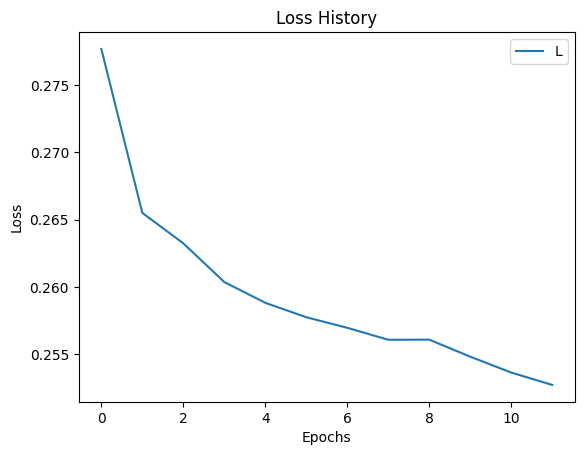

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

my_model = MyModel(input_shape, learning_rate)
my_model.build_model()
my_model.compile()

my_model.train(train_ds, epochs=12)
# my_model.evaluate(test_ds)


Model Without Using Class: Model 2


In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
lstm = tf.keras.layers.LSTM(128)
x = lstm(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}


model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 25, 3)]      0           []                               
                                                                                                  
 lstm_6 (LSTM)                  (None, 128)          67584       ['input_7[0][0]']                
                                                                                                  
 duration (Dense)               (None, 1)            129         ['lstm_6[0][0]']                 
                                                                                                  
 pitch (Dense)                  (None, 128)          16512       ['lstm_6[0][0]']                 
                                                                                            

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
408/408 [==============================] - 29s 52ms/step - loss: 0.2775 - duration_loss: 0.0501 - pitch_loss: 4.1436 - step_loss: 0.0202
Epoch 2/50
408/408 [==============================] - 24s 58ms/step - loss: 0.2652 - duration_loss: 0.0480 - pitch_loss: 4.0330 - step_loss: 0.0156
Epoch 3/50
408/408 [==============================] - 21s 53ms/step - loss: 0.2631 - duration_loss: 0.0473 - pitch_loss: 4.0063 - step_loss: 0.0155
Epoch 4/50
408/408 [==============================] - 21s 51ms/step - loss: 0.2610 - duration_loss: 0.0472 - pitch_loss: 3.9690 - step_loss: 0.0154
Epoch 5/50
408/408 [==============================] - 24s 58ms/step - loss: 0.2589 - duration_loss: 0.0467 - pitch_loss: 3.9394 - step_loss: 0.0152
Epoch 6/50
408/408 [==============================] - 22s 54ms/step - loss: 0.2569 - duration_loss: 0.0456 - pitch_loss: 3.9258 - step_loss: 0.0150
Epoch 7/50
408/408 [==============================] - 23s 55ms/step - loss: 0.2571 - duration_loss: 0.0456 - pit

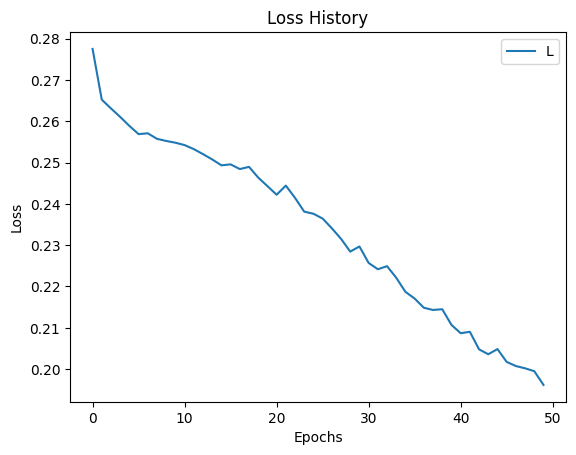

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.legend("Loss")
plt.title("Loss History")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    keras_model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']
  print(pitch_logits.shape, step.shape, duration.shape)

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
temperature = 4.0
num_predictions = 120
key_order = ['pitch', 'step', 'duration']
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
temperature = 4.0
num_predictions = 120
key_order = ['pitch', 'step', 'duration']
sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = my_model.predict_next_note(input_notes, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

In [ ]:
generated_notes

,pitch,step,duration,start,end
0,73,0.079419,0.060257,0.079419,0.139676
1,92,0.000000,0.000000,0.079419,0.079419
2,83,0.000000,0.022077,0.079419,0.101496
3,83,0.000000,0.022370,0.079419,0.101789
4,31,0.000000,0.035453,0.079419,0.114872
...,...,...,...,...,...
115,59,0.052319,0.378953,4.954791,5.333744
116,45,0.050803,0.376697,5.005595,5.382291
117,68,0.052258,0.371344,5.057853,5.429196
118,86,0.051756,0.378386,5.109609,5.487995


In [ ]:
generated_notes

,pitch,step,duration,start,end
0,78,0.041462,0.097207,0.041462,0.138669
1,80,0.093810,0.628759,0.135272,0.764031
2,96,0.156496,0.762041,0.291769,1.053810
3,76,0.167121,0.785154,0.458890,1.244044
4,51,0.167194,0.779808,0.626084,1.405892
...,...,...,...,...,...
115,65,0.175101,0.859522,20.103543,20.963065
116,63,0.173592,0.844620,20.277135,21.121755
117,58,0.175073,0.841967,20.452208,21.294175
118,84,0.176743,0.834458,20.628951,21.463409


In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
out_file = 'output.mid'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
display_audio(sample_file_pm(2))

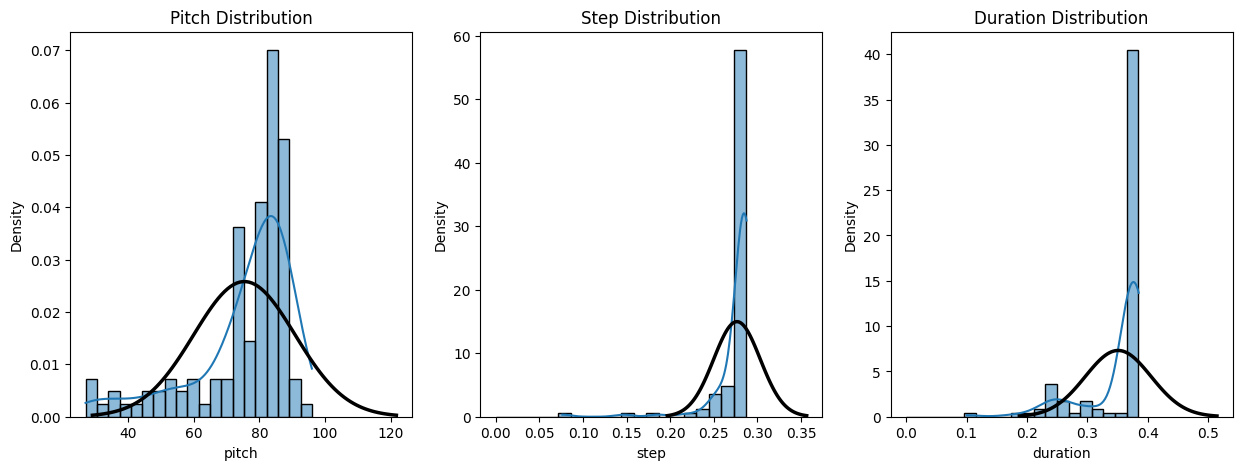

In [ ]:
plot_distributions2(generated_notes)

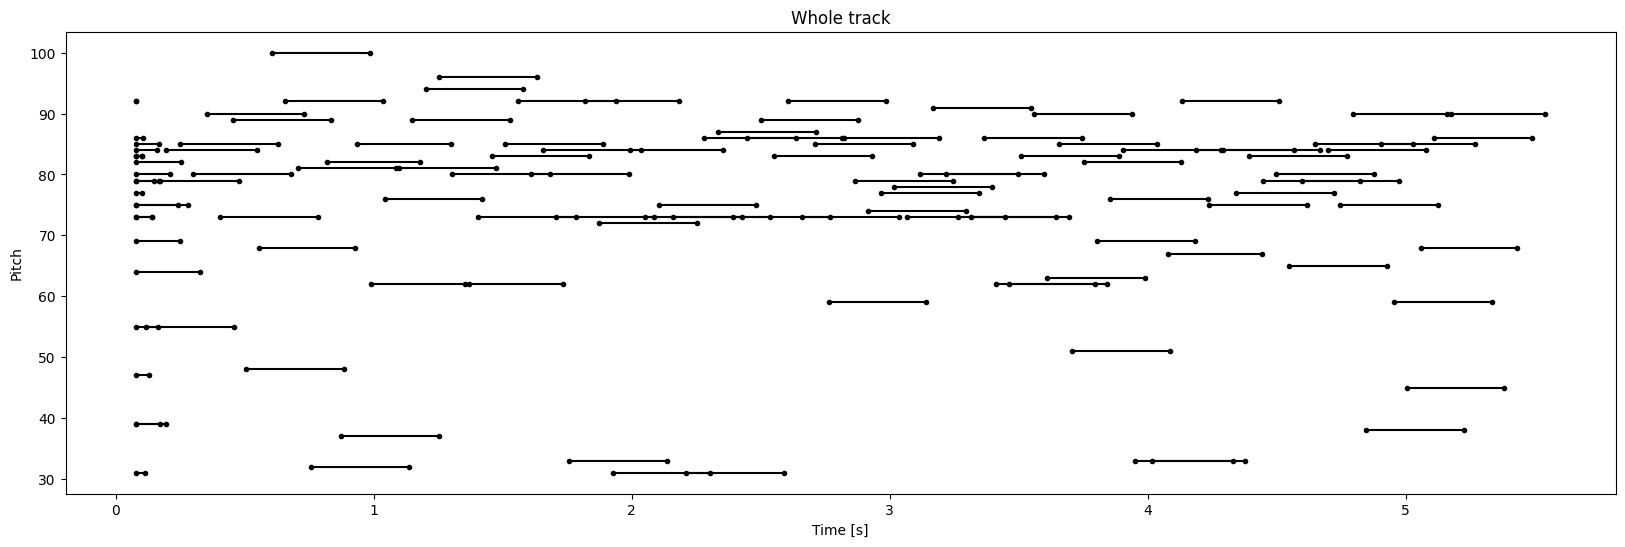

In [ ]:
plot_piano_roll(generated_notes)

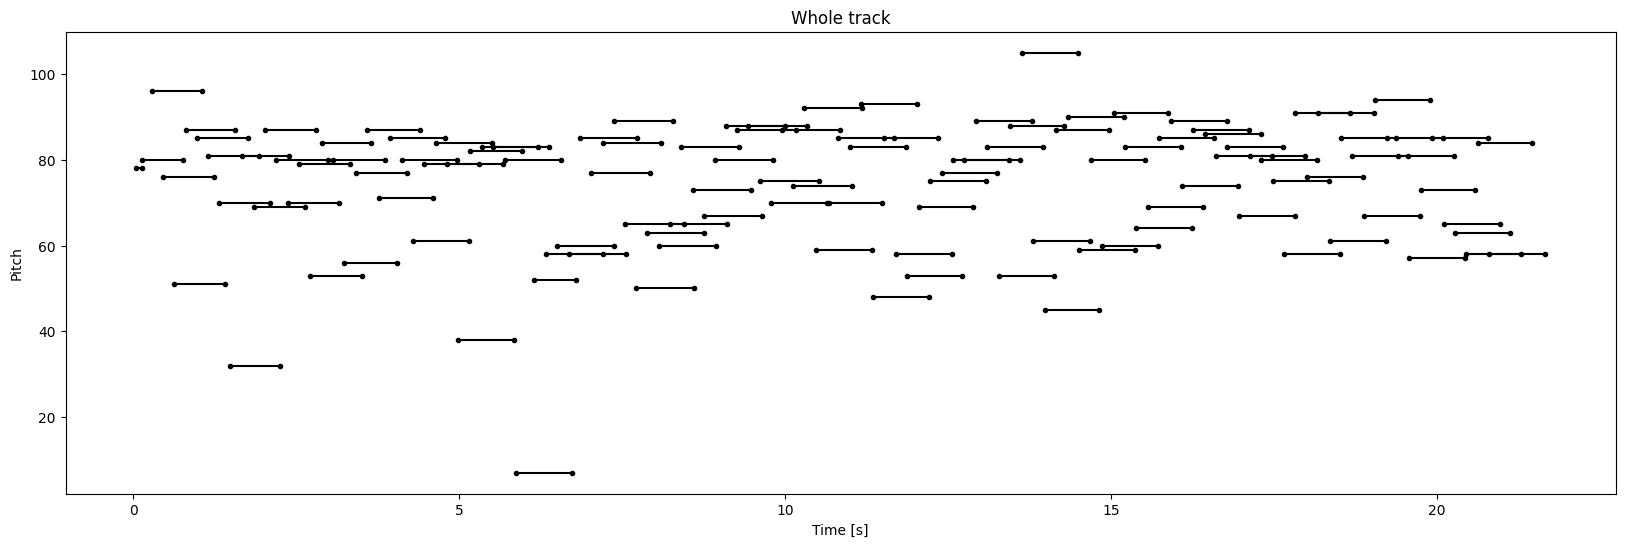

In [ ]:
plot_piano_roll(generated_notes)